In [1]:
#################################################################
#
# Estimate pendulum state with UKF and URTS as in Examples 5.3
# and 9.3 of the book
#
# Simo Sarkka (2013), Bayesian Filtering and Smoothing,
# Cambridge University Press. 
#
# Last updated: $Date: 2013/08/26 12:58:41 $.
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.
#
#################################################################

In [2]:
import numpy as np
from numpy.linalg import cholesky, solve

import plotly.graph_objects as go
from plotly.subplots import make_subplots

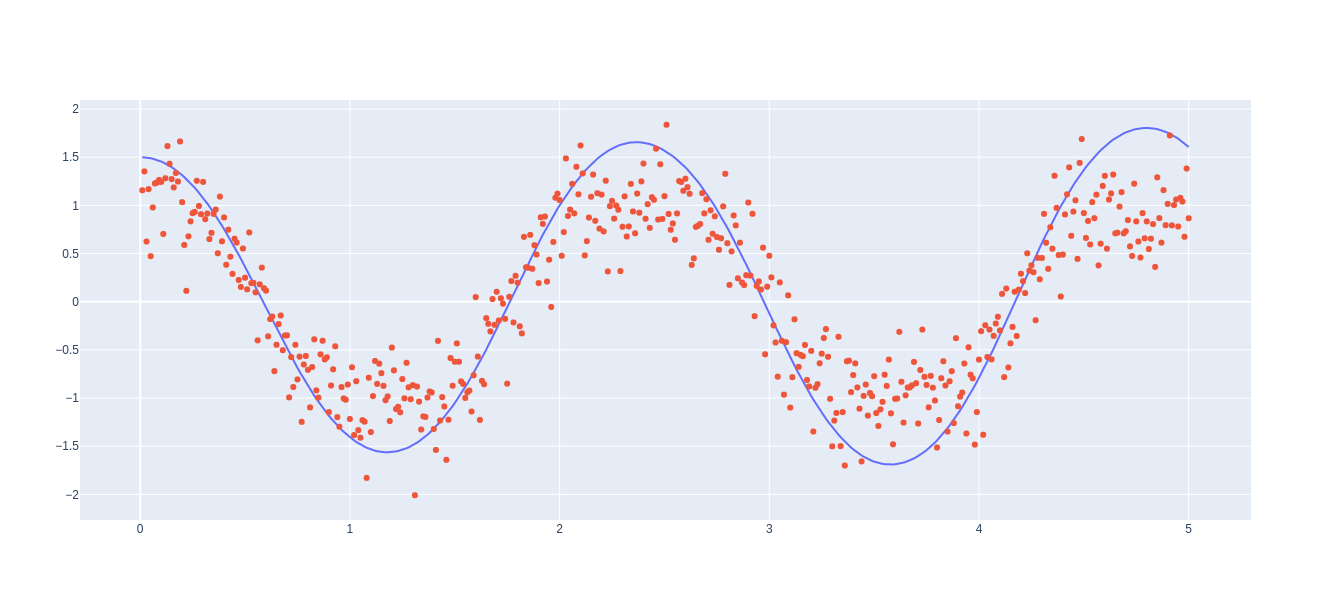

In [3]:
##
# Simulate data
##

from pendulum_sim import dt, T, m0, P0, Q, R, g, X, Y

In [4]:
##
# Filter
##

m = m0
P = P0

#
# Precompute the UT weights
#
n = m.shape[0]
y_ = len(Y)
p_1, p_2 = P.shape

alpha = 1
beta = 0
kappa = 3-n

lbda = alpha**2 * (n + kappa) - n        
WM = np.zeros((2*n+1,1))
WC = np.zeros((2*n+1,1))
WM[0] = lbda / (n + lbda)
WC[0] = lbda / (n + lbda) + (1 - alpha**2 + beta)
for j in range(1,2*n+1):
    wm = 1 / (2 * (n + lbda))
    WM[j] = wm
    WC[j] = wm

In [5]:
# Do the filtering  
MM = np.zeros((y_,n,1))
PP = np.zeros((y_,p_1,p_2))
for k in range(y_):

    # Form the sigma points for dynamic model
    A = cholesky(P)
    SX = np.hstack([np.zeros(m.shape), A, -A])
    SX = np.sqrt(n + lbda)*SX + np.tile(m,SX.shape[1])

    # Propagate through the dynamic model
    HX = np.array([SX[0]+SX[1]*dt, SX[1]-g*np.sin(SX[0])*dt])

    # Compute the predicted mean and covariance
    m = HX@WM
    P = WC.T*(HX-m) @ (HX-m).T + Q

    # Form sigma points for measurement step and
    # propagate throught the measurement model
    A = cholesky(P)
    SX = np.hstack([np.zeros(m.shape), A, -A])
    SX = np.tile(m,SX.shape[1]) + np.sqrt(n + lbda)*SX
    HY = np.sin(SX[0])[None]

    # Compute the updated mean and covariance
    mu = HY@WM
    S = WC.T * (HY-mu) @ (HY-mu).T + R
    C = WC.T * (SX-m) @ (HY-mu).T

    # Compute the gain and updated mean and covariance  
    K = solve(S.T, C.T).T
    m += K@(Y[k] - mu)
    P -= K@S@K.T

    MM[k] = m
    PP[k] = P


rmse_ukf = np.sqrt(np.mean((X[:,0,0]-MM[:,0,0])**2))
rmse_ukf

0.08011274743689548

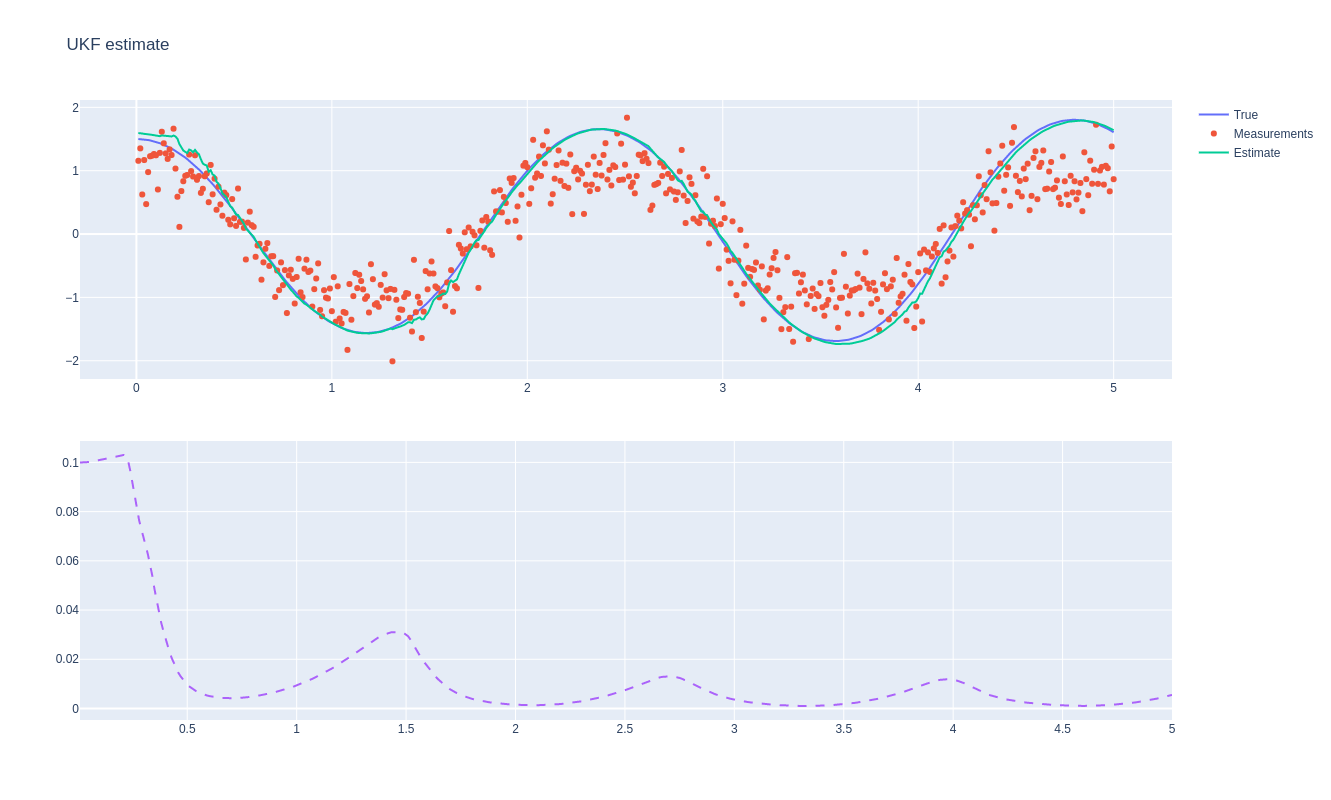

In [6]:
fig = go.Figure(make_subplots(rows=2,cols=1, vertical_spacing=0.1))
fig.add_scatter(x=T, y=X[:,0,0], name='True', row=1, col=1)
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements', row=1, col=1)
fig.add_scatter(x=T, y=MM[:,0,0], name='Estimate', row=1, col=1)
fig.add_scatter(x=T, y=PP[:,0,0], line_dash='dash', showlegend=False, row=2, col=1)
fig.layout.update(title='UKF estimate', height=800)
fig.show()

In [7]:
##
# Smoother
##

ms = m
Ps = P
MMS = np.zeros((y_,n,1))
PPS = np.zeros((y_,p_1,p_2))
MMS[k] = m
PPS[k] = P
for k in range(y_-2,-1,-1):
    m = MM[k]
    P = PP[k]

    # Form the sigma points for dynamic model
    A = cholesky(P)
    SX = np.hstack([np.zeros(m.shape), A, -A])
    SX = np.tile(m,SX.shape[1]) + np.sqrt(n + lbda)*SX

    # Propagate through the dynamic model
    HX = np.array([SX[0]+SX[1]*dt, SX[1]-g*np.sin(SX[0])*dt])

    # Compute the predicted mean and covariance
    # and the cross-covariance D.
    mp = HX@WM
    Pp = WC.T * (HX-mp) @ (HX-mp).T + Q
    D  = WC.T * (SX-m) @ (HX-mp).T

    Ck = solve(Pp.T, D.T).T
    ms = m + Ck @ (ms-mp)
    Ps = P + Ck @ (Ps-Pp) @ Ck.T
    MMS[k] = ms
    PPS[k] = Ps


rmse_urts = np.sqrt(np.mean((X[:,0,0]-MMS[:,0,0])**2))
rmse_urts

0.037708201347533124

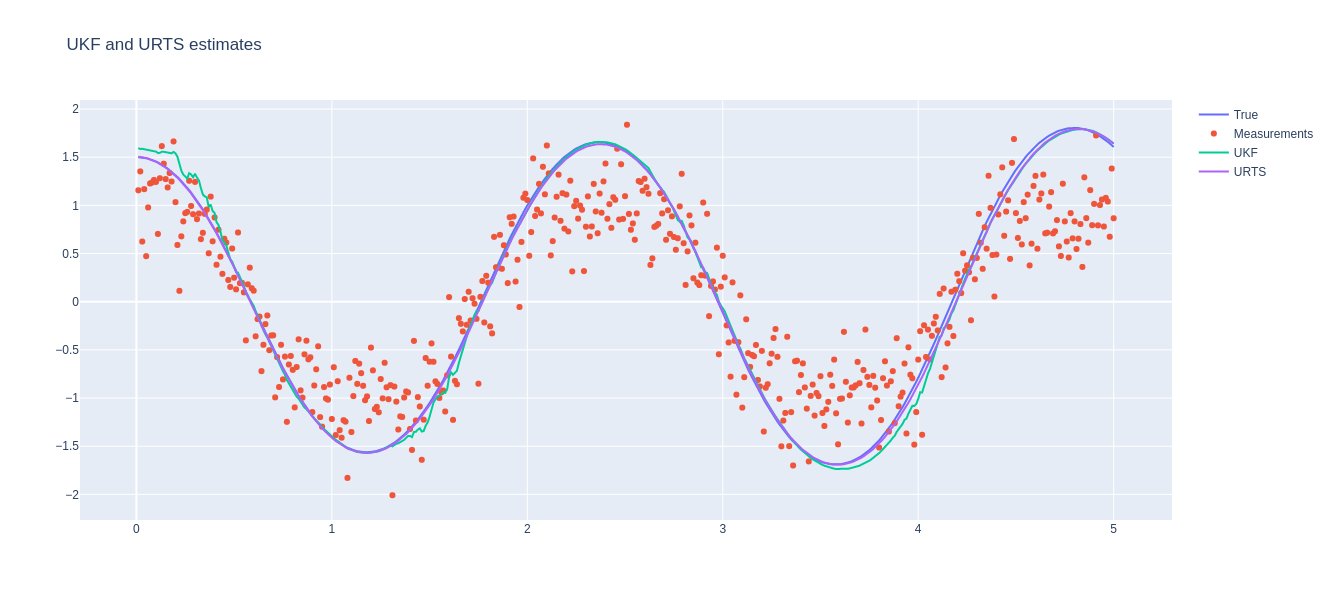

In [8]:
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MM[:,0,0], name='UKF')
fig.add_scatter(x=T, y=MMS[:,0,0], name='URTS')
fig.layout.update(title='UKF and URTS estimates', height=600)
fig.show()

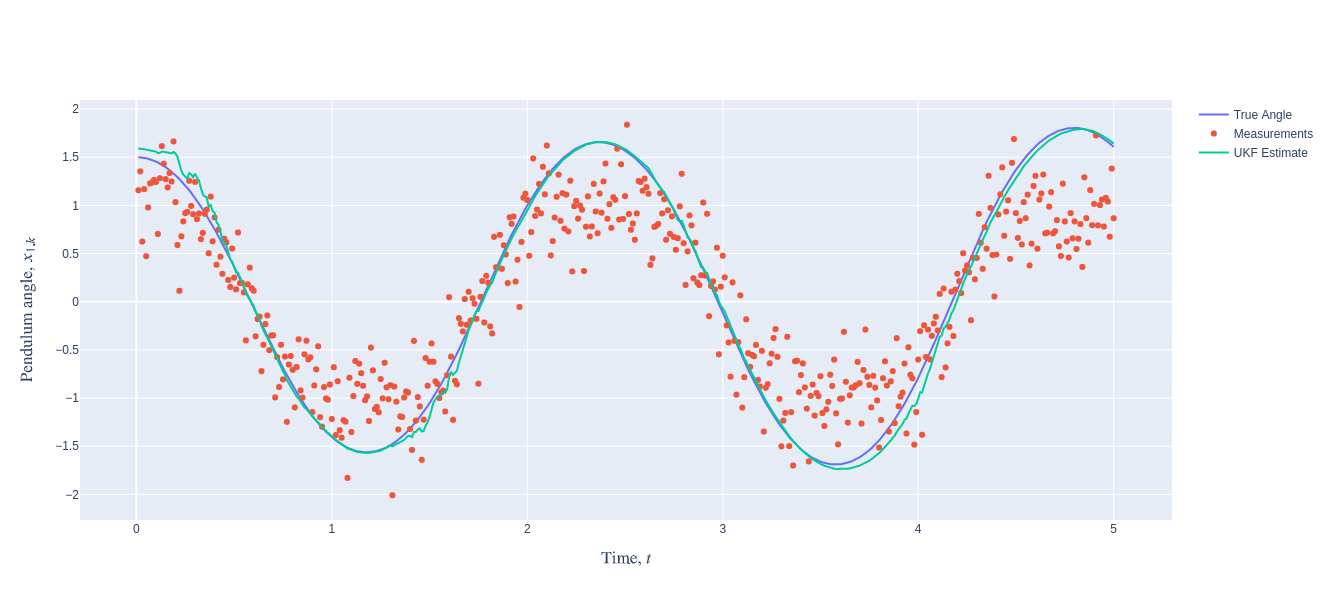

In [9]:
# Plot the filtering result
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True Angle')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MM[:,0,0], name='UKF Estimate')
fig.layout.update(xaxis_title='$\\text{Time, }t$', yaxis_title='$\\text{Pendulum angle, }x_{1,k}$', height=600)
fig.show()

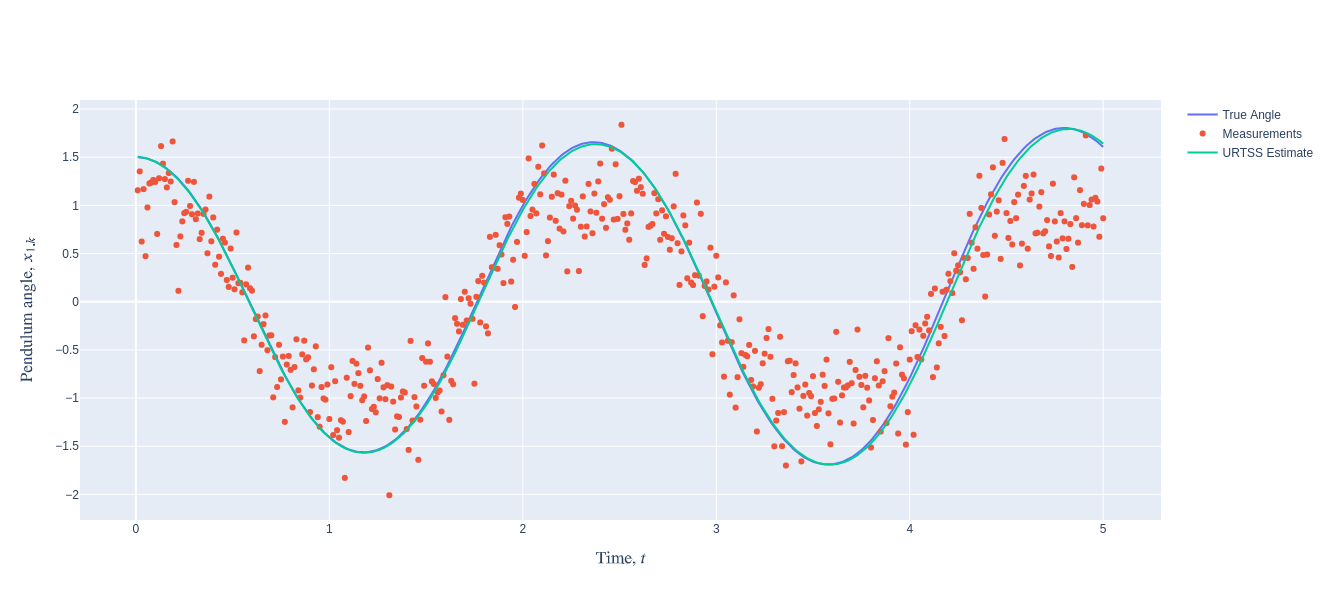

In [10]:
# Plot the smoothing result
fig = go.Figure()
fig.add_scatter(x=T, y=X[:,0,0], name='True Angle')
fig.add_scatter(x=T, y=Y[:,0,0], mode='markers', name='Measurements')
fig.add_scatter(x=T, y=MMS[:,0,0], name='URTSS Estimate')
fig.layout.update(xaxis_title='$\\text{Time, }t$', yaxis_title='$\\text{Pendulum angle, }x_{1,k}$', height=600)
fig.show()